In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM.MinimalModelSemisymbolic

using Base.Threads
using JLD2
using DataFrames, FreqTables, AlgebraOfGraphics, NamedArrays, StatsBase
using EnumX

In [2]:
using GLMakie
using CairoMakie
# CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)
# ENV["COLUMNS"] = 280

# Phase diagrams

In [3]:
function do_single(m, l, K, c, d, DN, DG, DR; threshold=10*eps())
    mmpns = MinimalModelParamsNoSpace(m, l, K, c, d)
    mmicrm_params = mmp_to_mmicrm(mmpns)
    
    ns_status, maybe_nssols = mmp_nospace_sol(mmpns; threshold)

    found_valid_ss = false

    nospace_stable_ss_M1 = nothing
    if ns_status == MMNoSpaceSolType.onepositive
        M1 = make_M1(mmicrm_params, maybe_nssols)

        M1evals = eigvals(M1)
        
        if all(l -> real(l) < -threshold, M1evals) # it is stable
            found_valid_ss = true
            nospace_stable_ss_M1 = M1
        else
            return 0
            # return -6
        end
    elseif ns_status == MMNoSpaceSolType.bothpositive
        M1p = make_M1(mmicrm_params, maybe_nssols[1])
        M1m = make_M1(mmicrm_params, maybe_nssols[2])

        pstable = all(l -> real(l) < -threshold, eigvals(M1p))
        mstable = all(l -> real(l) < -threshold, eigvals(M1m))

        if pstable && !mstable # we think this should always be the case
            found_valid_ss = true
            nospace_stable_ss_M1 = M1p
        elseif pstable && mstable
            return -1
        elseif !pstable && !mstable
            return -2
        else
            return -3
        end
    elseif isnothing(maybe_nssols) # not really a debug code
        return 0
        # if ns_status == MMNoSpaceSolType.imaginary
        #     return -4
        # else
        #     return -5
        # end
    else # something odd
        @error (@sprintf "encountered an unrecognized return type of mmp_nospace_sol %s" string(ns_status))
        return -100
    end

    if found_valid_ss
        Ds = SA[DN, DG, DR]

        M1 = nospace_stable_ss_M1
        Kp = make_K_polynomial_mm(M1, Ds)
        kroots = find_ks_that_have_nullspace(Kp; threshold)
        k_samples = sample_ks_from_nullspace_ks(kroots)

        has_instability = false
        for k in k_samples
            evals = eigvals!(M1_to_M(M1, Ds, k); sortby=eigen_sortby_reverse)
            if real(evals[1]) > threshold
                has_instability = true
                break
            end
        end

        if has_instability
            return 2
        else
            return 1
        end
    else
        @show ns_status
        throw(ErrorException("did not find a valid ss but debug was not set either"))
    end
end
minval = -5
maxval = 2
(minval, maxval)

(-5, 2)

In [20]:
pnames = ["m", "l", "K", "c", "d", "DN", "DG", "DR"]

# Base with K, DG = 1
pranges = [
    2 .^ LinRange(-10, 10, 100),  # m
    LinRange(0.0, 1.0, 100),    # l
    # [1.0],                     # K
    2 .^ LinRange(-10, 10, 100), # K
    2 .^ LinRange(-10, 30, 80), # c
    2 .^ LinRange(-10, 30, 80), # d
    10 .^ LinRange(-9, -2, 8), # DN
    [1.0],                     # DG
    10 .^ LinRange(-7, 5, 40), # DR
];

# pranges = [
#     2 .^ LinRange(-10, 10, 100),  # m
#     LinRange(0.0, 1.0, 100),    # l
#     2 .^ LinRange(-10, 10, 100),  # K
#     2 .^ LinRange(-10, 40, 80), # c
#     2 .^ LinRange(-10, 40, 80), # d
#     [0.; 10 .^ LinRange(-10, -2, 100)], # DN
#     [0; 10 .^ LinRange(-10, 5, 100)], # DR
#     [0; 10 .^ LinRange(-7, 5, 100)], # DR
# ];

In [22]:
function pp1(xn, yn;
        logx=nothing,
        logy=nothing,
        noise=nothing,
        xnoise=noise,
        ynoise=noise,
        colormap=:viridis,
        threshold=10*eps()
    )
    sspecs = []
    pindices = []
    xi = nothing
    yi = nothing
    xs = nothing
    ys = nothing
    displayxs = nothing
    displayys = nothing
    for i in 1:length(pnames)
        pn = pnames[i]
        pr = pranges[i]
        if pn == xn
            xi = i
            xs = pr
            displayxs = pr
        elseif pn == yn
            yi = i
            ys = pr
            displayys = pr
        else
            push!(sspecs, (label=pn, range=pr))
            push!(pindices, i)
        end
    end

    if !isnothing(logx)
        displayxs = log.(logx, displayxs)
    end
    if !isnothing(logy)
        displayys = log.(logy, displayys)
    end
    
    fig = Figure()
    sg = SliderGrid(fig[1, 1:2], sspecs...)

    svalso = [s.value for s in sg.sliders]
    smd = lift(svalso...) do svals...
        xx = Vector{Any}(undef, length(pnames))
        for (i, sval) in enumerate(svals)
            xx[pindices[i]] = sval
        end
        xx[xi] = xs
        xx[yi] = transpose(ys)
        do_single.(xx...; threshold)
    end

    ax = Axis(fig[2, 1])
    hm = heatmap!(
        ax, displayxs, displayys, smd;
        colorrange=(minval, maxval),
        colormap
    )
    Colorbar(fig[2, 2], hm)

    xlabel = isnothing(logx) ? xn : "log"*string(logx)*" "*xn
    ax.xlabel = xlabel
    ylabel = isnothing(logy) ? yn : "log"*string(logy)*" "*yn
    ax.ylabel = ylabel
    
    fig, smd
end

pp1 (generic function with 1 method)

In [23]:
xx = pp1("c", "d"; logx=2, logy=2, colormap=:tab10, threshold=10*eps())
display(GLMakie.Screen(), xx[1])

GLMakie.Screen(...)

In [208]:
xx = pp1("m", "l"; logx=2, colormap=:tab10)
display(GLMakie.Screen(), xx[1])

GLMakie.Screen(...)

In [61]:
# save(datadir("minimalmodel/pscan_plots/kaka.png"), xx[1])

# Additional numerics for a single system

### Space unlocked stability params

In [ ]:
MinimalModelParamsSpace()

In [8]:
mmpf = MinimalModelParamsSpace(500., 1., 1., 2. ^ 14, 2. ^ 14, 1e-9, 1., 1e-7)
mmicrm_params = mmp_to_mmicrm(mmpf);
Ds = get_Ds(mmpf)
xx = mmp_nospace_sol(mmpf)
xx[2]

mmpf

MinimalModelParamsSpace{Float64}(500.0, 1.0, 1.0, 16384.0, 16384.0, 1.0e-9, 1.0, 1.0e-7)

In [9]:
M1p = make_M1(mmicrm_params, xx[2][1])
M1n = make_M1(mmicrm_params, xx[2][2])
@show eigvals(M1p)
@show eigvals(M1n)
nothing

eigvals(M1p) = ComplexF64[-103.01220403465244 + 0.0im, 19.770637722347743 - 64.72631236188957im, 19.770637722347743 + 64.72631236188957im]
eigvals(M1n) = [-22.90007145669592, -0.9989436823627785, 21.83394372901935]


In [10]:
nssol = xx[2][1]

3-element Vector{Float64}:
 0.0018759438656603094
 0.03151048904484532
 0.030517578125000003

### Others

In [91]:
mmpf = MinimalModelParamsSpace(500., 1., 1., 2. ^ 14, 2. ^ 14, 1e-9, 1., 1e-7)
mmicrm_params = mmp_to_mmicrm(mmpf);
Ds = get_Ds(mmpf)

mmpf

MinimalModelParamsSpace{Float64}(500.0, 1.0, 1.0, 16384.0, 16384.0, 1.0e-9, 1.0, 1.0e-7)

In [92]:
xx = analyze_single_mmps_Kpoly(mmpf; include_extinct=false)
println((xx[1], xx[2]))
print("sss: ")
show(xx[3])
println()
print("kroots fe ss: ")
show(xx[4])
println()
print("nummodes fe ss fe segment: ")
show(xx[5])

(0, 0)
sss: Vector{Float64}[]
kroots fe ss: Vector{Float64}[]
nummodes fe ss fe segment: Vector{Int64}[]

## Numerics

#### No space solver

3-element Vector{Float64}:
 1.4307834661064265e-33
 0.9999999999999076
 1.6825580832640092e-15

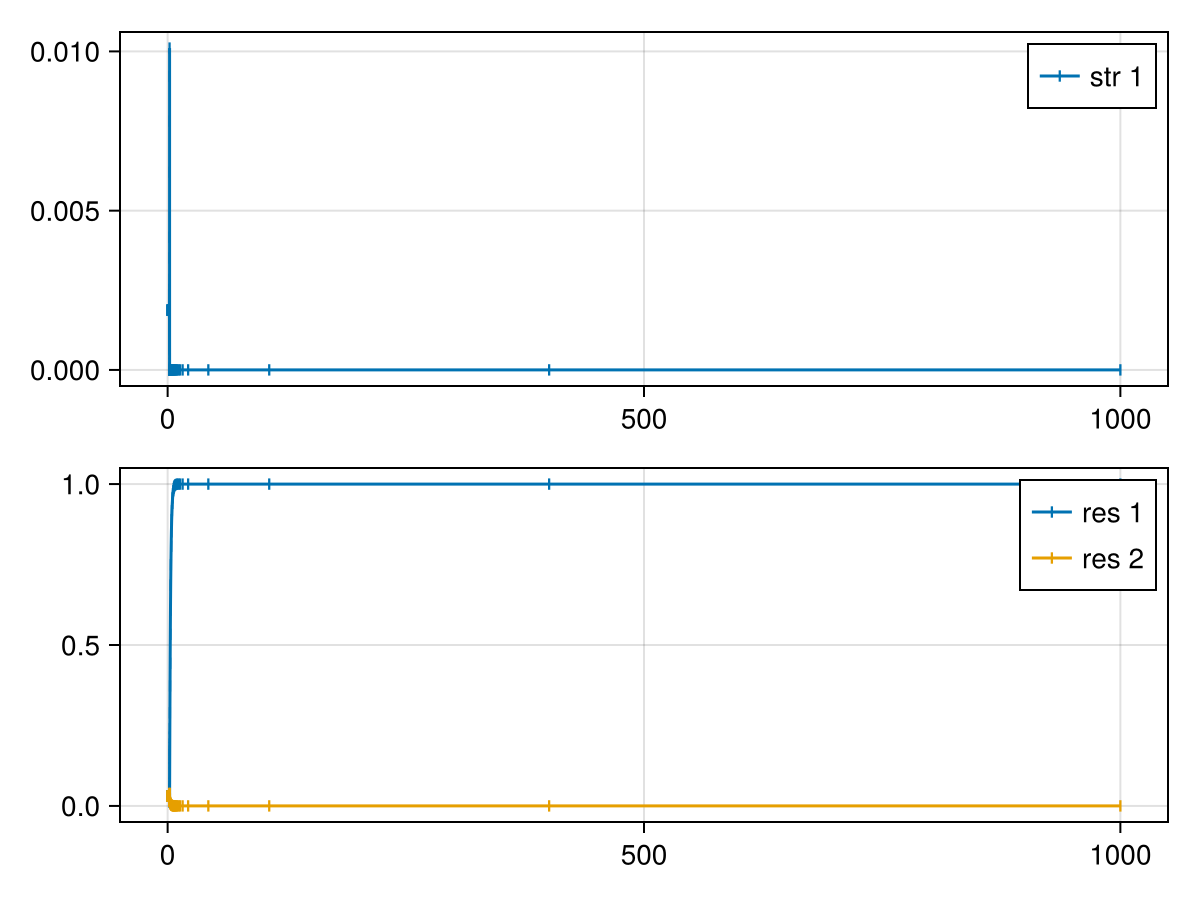

In [11]:
# u0 = make_u0_smart(mmicrm_params; u0=:maxNs)
u0 = nssol
# u0 = xx[2][2]
nsp = make_mmicrm_problem(mmicrm_params, u0, 1000)

s = solve(nsp)
display(s.u[end])
plot_mmicrm_sol(s)

#### Linstab

mrl = 19.770637722347743


[ Info: Unstable, mrl is 19.7706


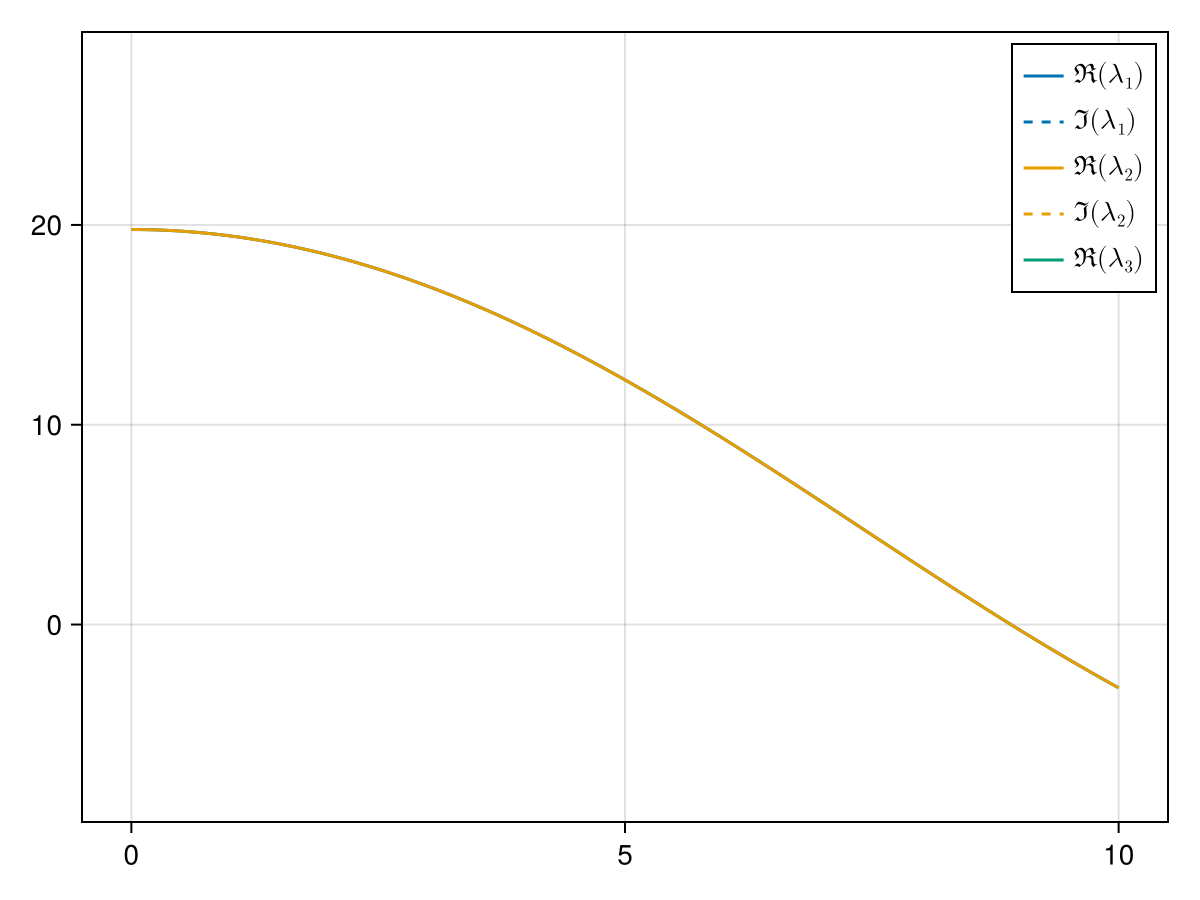

In [12]:
ks = LinRange(0., 10., 10000)

lambda_func = linstab_make_k_func(mmicrm_params, Ds, nssol)
full_linstab_func = linstab_make_k_func(mmicrm_params, Ds, nssol; returnobj=:full)

lambdas = lambda_func.(ks)
mrl = maximum(x->maximum(real,x), lambdas)
@show mrl

faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-0.5, 1.5) .* abs(mrl))
# xlims!(faa.axis, (0., 2.))
# display(GLMakie.Screen(), faa.figure)
faa

In [31]:
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
@show kmax
flmax = full_linstab_func(kmax)
flmax.vectors[:,1]

kmax = 0.0


3-element Vector{ComplexF64}:
 -0.09302660752856459 + 0.1169039981871521im
   0.9324457688329081 - 0.0im
  0.18635050676507464 + 0.27110492860439067im

### 1D PDE sim

In [13]:
ssize = (20000,)
su0 = expand_u0_to_size(ssize, nssol)
psu0 = perturb_u0_uniform_prop(get_Ns(mmicrm_params)..., su0, 0.01, 0.01)

space = make_cartesianspace_smart(length(ssize); dx=0.0000001, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing

sparams = SASMMiCRMParams(mmicrm_params, get_Ds(mmpf), space)
sp = make_smmicrm_problem(sparams, psu0, 10000)

size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 20000), nothing, CartesianSpace{1, Tuple{Periodic}, Float64}([1.0e-7]))

In [14]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

  9.966008 seconds (13.69 M allocations: 5.269 GiB, 4.78% gc time, 48.05% compilation time)
Success
nf is 623
solution has 130 saved states
max resid is 0.00068037


┌ Warning: reaching negative values, minimum is -6.78848e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


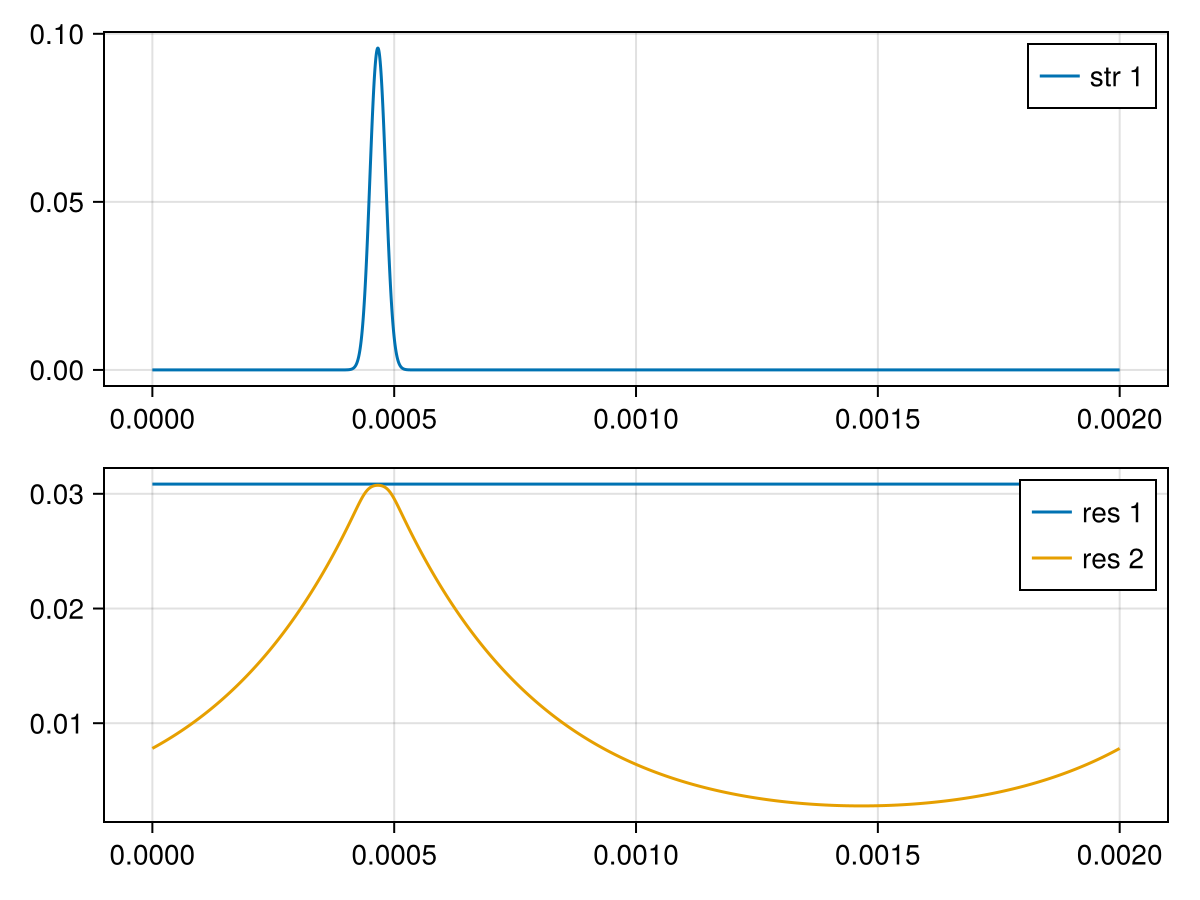

In [18]:
f = plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
# display(GLMakie.Screen(), f)
f

# Extras

In [185]:
empty!(Out)
GC.gc()

### Testing scanning k stability analysis

In [311]:
N = 10000
ks = LinRange(0., 100., 10000)
for _ in 1:N
    dfrow = get_random_row(df)
    mmpf = df_row_to_mmp(dfrow)
    xx = analyze_single_mmps_kscan(mmpf, ks)
    if xx[2] != dfrow.nummodes
        @show xx# dfrow.numss dfrow.nummodes
        @show analyze_single_mmps_Kpoly(mmpf)
    end
end

xx = (1, 0, [[6.545830699535399, 2.270846502323003, 3.5458306995354]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[6.545830699535399, 2.270846502323003, 3.5458306995354]], [[931.9578870634543, 1729.2162096971135]], [[0, 1, 0]])
xx = (1, 0, [[9.692781856144013, 5.473462242551887, 4.537250088781851]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[9.692781856144013, 5.473462242551887, 4.537250088781851]], [[197.68498245367596, 537.0239594988301]], [[0, 1, 0]])
xx = (1, 0, [[6.096440684786595, 0.11729438402027532, 1.2718090912490065]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[6.096440684786595, 0.11729438402027532, 1.2718090912490065]], [[129.39270782668513, 480.2555950791281]], [[0, 1, 0]])
xx = (1, 0, [[3.032088680599828, 0.1179058233838167, 1.8187325263624383]], Bool[1])
analyze_single_mmps_Kpoly(mmpf) = (1, 1, [[3.032088680599828, 0.1179058233838167, 1.8187325263624383]], [[489.0872723237346, 1165.965811445184]], [[0, 1, 0]])
xx = (1, 0, [[36.730217501626626, 0

┌ Warning: error in renderloop
│   exception =
│    InterruptException:
│    Stacktrace:
│      [1] poptask(W::Base.IntrusiveLinkedListSynchronized{Task})
│        @ Base ./task.jl:999
│      [2] wait()
│        @ Base ./task.jl:1008
│      [3] wait(c::Base.GenericCondition{SpinLock}; first::Bool)
│        @ Base ./condition.jl:130
│      [4] wait
│        @ ./condition.jl:125 [inlined]
│      [5] _trywait(t::Timer)
│        @ Base ./asyncevent.jl:142
│      [6] wait
│        @ ./asyncevent.jl:159 [inlined]
│      [7] sleep(sec::Float64)
│        @ Base ./asyncevent.jl:265
│      [8] sleep(timer::Makie.BudgetedTimer)
│        @ Makie ~/.julia/packages/Makie/ux0Te/src/utilities/timing.jl:121
│      [9] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
│        @ GLMakie ~/.julia/packages/GLMakie/87u59/src/screen.jl:1044
│     [10] renderloop(screen::GLMakie.Screen{GLFW.Window})
│        @ GLMakie ~/.julia/packages/GLMakie/87u59/src/screen.jl:1061
│     [11] (::GLMakie.var"#79#80